In [646]:
#TO RE-RUN
%reset -f

In [647]:
from sklearn import preprocessing
from time import time
import numpy as np
import csv
from sklearn import metrics
from sklearn.preprocessing import scale
from sklearn.feature_selection import VarianceThreshold
from sklearn.cross_validation import StratifiedShuffleSplit

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.grid_search import GridSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline


from sklearn.metrics import pairwise_distances
from IPython.display import display, HTML
from operator import truediv
import pandas as pd
import time
import os

from pylab import *
import seaborn as sns
import matplotlib.pyplot as plt


np.set_printoptions(suppress=True)
pd.options.display.float_format = '{:,.3f}'.format
plt.style.use('classic')

%matplotlib inline

import sys
sys.path.insert(1, "../../src/")
from TypeFeatImputer import TypeFeatImputer

In [648]:
#df_all=pd.read_csv(os.path.join('resources','diabetic_data_processed_withweight.csv'),';')
#df_all=pd.read_csv(os.path.join('resources','diabetic_data_processed_2017_09_28.csv'),';')
df_all=pd.read_csv(os.path.join('resources','diabetic_data_extended_2017_09_29_14_xrp.csv'),',')

In [649]:
print df_all.shape
print df_all.columns
print len(df_all.patient_nbr.unique())
print df_all.readmitted.value_counts()
print df_all.race.unique()

(101766, 88)
Index([u'Unnamed: 0', u'encounter_id', u'patient_nbr', u'race', u'gender',
       u'age', u'weight', u'admission_type_id', u'discharge_disposition_id',
       u'admission_source_id', u'time_in_hospital', u'payer_code',
       u'medical_specialty', u'num_lab_procedures', u'num_procedures',
       u'num_medications', u'number_outpatient', u'number_emergency',
       u'number_inpatient', u'number_diagnoses', u'max_glu_serum',
       u'A1Cresult', u'metformin', u'repaglinide', u'nateglinide',
       u'chlorpropamide', u'glimepiride', u'acetohexamide', u'glipizide',
       u'glyburide', u'tolbutamide', u'pioglitazone', u'rosiglitazone',
       u'acarbose', u'miglitol', u'troglitazone', u'tolazamide', u'examide',
       u'citoglipton', u'insulin', u'glyburide-metformin',
       u'glipizide-metformin', u'glimepiride-pioglitazone',
       u'metformin-rosiglitazone', u'metformin-pioglitazone', u'Change',
       u'diabetesMed', u'readmitted', u'Diabetis_3', u'External causes_3',
   

#### Group rows by patient and get last one

In [650]:
typeEncounter = "last" #["first","last"]

In [651]:
if typeEncounter == "last":
    df=df_all.groupby(['patient_nbr'], sort=True).last()
else:
    df=df_all.groupby(['patient_nbr'], sort=True).first()

df.readmitted.value_counts()
print len(df.encounter_id.unique())

71518


In [652]:
pd.value_counts(df.Diabetis_1)

0    65713
1     5805
Name: Diabetis_1, dtype: int64

#### Null values

,%_Null,#_Null,#_No_Null
A1Cresult,0.785,56130,15388
gender,0.000,3,71515
max_glu_serum,0.949,67906,3612
medical_specialty,0.459,32843,38675
payer_code,0.419,29985,41533
race,0.026,1850,69668
weight,0.960,68652,2866


(7, 3)


<function matplotlib.pyplot.show>

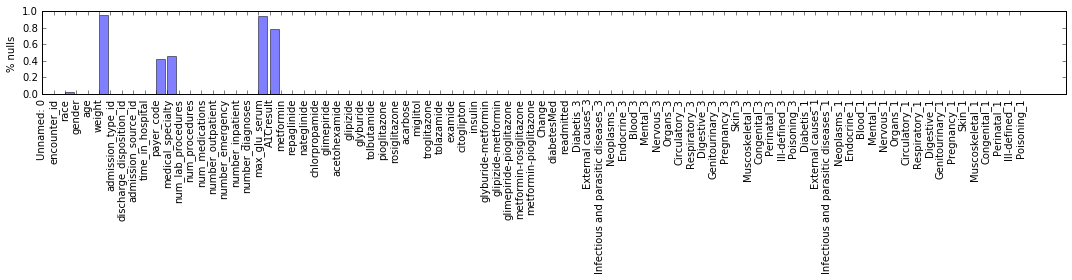

In [653]:
dfNull = np.sum(df.isnull()) / float(df.shape[0])
dfNullAll = pd.concat([dfNull[dfNull>0],np.sum(df.isnull()),np.sum(df.isnull()==False)], axis=1)
dfNullAll.columns= ["%_Null","#_Null","#_No_Null"]

display(dfNullAll[dfNullAll.iloc[:,0].isnull() == False][["%_Null","#_Null","#_No_Null"]])
print dfNullAll[dfNullAll.iloc[:,0].isnull() == False].shape


plt.figure(figsize=(15,4))
plt.bar(range(dfNull.shape[0]),dfNull.iloc[:], alpha=0.5)
plt.xticks(range(dfNull.shape[0]),dfNull.index,rotation=90)
plt.ylabel("% nulls")
plt.tight_layout()
plt.show

#### Remove highly null features

In [654]:
to_del = []

In [655]:
#to_del = ["A1Cresult","max_glu_serum","weight","medical_specialty"]

In [656]:
#Filter_selected cols
cols = [c for c in df.columns if (c not in to_del) ]#and ('ENF' not in c)
dfFiltered = df[cols]
print dfFiltered.shape
print dfFiltered.columns

(71518, 87)
Index([u'Unnamed: 0', u'encounter_id', u'race', u'gender', u'age', u'weight',
       u'admission_type_id', u'discharge_disposition_id',
       u'admission_source_id', u'time_in_hospital', u'payer_code',
       u'medical_specialty', u'num_lab_procedures', u'num_procedures',
       u'num_medications', u'number_outpatient', u'number_emergency',
       u'number_inpatient', u'number_diagnoses', u'max_glu_serum',
       u'A1Cresult', u'metformin', u'repaglinide', u'nateglinide',
       u'chlorpropamide', u'glimepiride', u'acetohexamide', u'glipizide',
       u'glyburide', u'tolbutamide', u'pioglitazone', u'rosiglitazone',
       u'acarbose', u'miglitol', u'troglitazone', u'tolazamide', u'examide',
       u'citoglipton', u'insulin', u'glyburide-metformin',
       u'glipizide-metformin', u'glimepiride-pioglitazone',
       u'metformin-rosiglitazone', u'metformin-pioglitazone', u'Change',
       u'diabetesMed', u'readmitted', u'Diabetis_3', u'External causes_3',
       u'Infectious 

#### Check Object (text) features 

In [657]:
for c in dfFiltered.columns:
    if dfFiltered[c].dtype == 'object':
        print c, len(dfFiltered[c].unique()),":"
        print pd.value_counts(dfFiltered[c]).index.tolist()
        print 

race 6 :
['Caucasian', 'AfricanAmerican', 'Hispanic', 'Other', 'Asian']

weight 10 :
['[75-100)', '[50-75)', '[100-125)', '[125-150)', '[25-50)', '[0-25)', '[150-175)', '[175-200)', '>200']

payer_code 18 :
['MC', 'HM', 'BC', 'SP', 'MD', 'CP', 'UN', 'CM', 'OG', 'PO', 'DM', 'WC', 'CH', 'OT', 'SI', 'MP', 'FR']

medical_specialty 71 :
['InternalMedicine', 'Family/GeneralPractice', 'Emergency/Trauma', 'Cardiology', 'Surgery-General', 'Orthopedics', 'Orthopedics-Reconstructive', 'Radiologist', 'Nephrology', 'Pulmonology', 'Psychiatry', 'ObstetricsandGynecology', 'Urology', 'Surgery-Cardiovascular/Thoracic', 'Gastroenterology', 'Surgery-Neuro', 'Surgery-Vascular', 'PhysicalMedicineandRehabilitation', 'Oncology', 'Pediatrics', 'Neurology', 'Pediatrics-Endocrinology', 'Hematology/Oncology', 'Otolaryngology', 'Endocrinology', 'Surgery-Thoracic', 'Surgery-Cardiovascular', 'Podiatry', 'Pediatrics-CriticalCare', 'Gynecology', 'Psychology', 'Surgeon', 'Radiology', 'Hospitalist', 'Osteopath', 'Hemat

#### Remove expired and loosed patients

In [658]:
print dfFiltered.shape
ix = dfFiltered[np.logical_not(dfFiltered['discharge_disposition_id'].isin([11,18,19,20,21,25,26]))].index
print len(ix)

dfFiltered = dfFiltered.ix[ix,:]
print dfFiltered.shape

(71518, 87)
67182
(67182, 87)


/home/ilmira/.conda/envs/readmision/lib/python2.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


#### Convert categorical feature into dummy

In [659]:
df_spec = pd.get_dummies(dfFiltered['medical_specialty'],dummy_na=False, prefix='medSpec')
for c in df_spec.columns:
    print c
    print pd.value_counts(df_spec[c])
    
df_clean = pd.concat([dfFiltered.iloc[:,:-1], df_spec], axis=1)
dfFiltered = pd.concat([df_clean, dfFiltered.iloc[:,-1]], axis=1)
print dfFiltered.shape
print dfFiltered.columns

medSpec_AllergyandImmunology
0    67176
1        6
Name: medSpec_AllergyandImmunology, dtype: int64
medSpec_Anesthesiology
0    67175
1        7
Name: medSpec_Anesthesiology, dtype: int64
medSpec_Anesthesiology-Pediatric
0    67170
1       12
Name: medSpec_Anesthesiology-Pediatric, dtype: int64
medSpec_Cardiology
0    62864
1     4318
Name: medSpec_Cardiology, dtype: int64
medSpec_Cardiology-Pediatric
0    67175
1        7
Name: medSpec_Cardiology-Pediatric, dtype: int64
medSpec_DCPTEAM
0    67177
1        5
Name: medSpec_DCPTEAM, dtype: int64
medSpec_Dentistry
0    67178
1        4
Name: medSpec_Dentistry, dtype: int64
medSpec_Dermatology
0    67181
1        1
Name: medSpec_Dermatology, dtype: int64
medSpec_Emergency/Trauma
0    62745
1     4437
Name: medSpec_Emergency/Trauma, dtype: int64
medSpec_Endocrinology
0    67090
1       92
Name: medSpec_Endocrinology, dtype: int64
medSpec_Endocrinology-Metabolism
0    67175
1        7
Name: medSpec_Endocrinology-Metabolism, dtype: int64
medS

In [660]:
dfFiltered["weight"][dfFiltered["weight"] == "[0-25)"] = 0
dfFiltered["weight"][dfFiltered["weight"] == "[25-50)"] = 1
dfFiltered["weight"][dfFiltered["weight"] == "[50-75)"] = 2
dfFiltered["weight"][dfFiltered["weight"] == "[75-100)"] = 3
dfFiltered["weight"][dfFiltered["weight"] == "[100-125)"] = 4
dfFiltered["weight"][dfFiltered["weight"] == "[125-150)"] = 5
dfFiltered["weight"][dfFiltered["weight"] == "[150-175)"] = 6
dfFiltered["weight"][dfFiltered["weight"] == "[175-200)"] = 7
dfFiltered["weight"][dfFiltered["weight"] == ">200"] = 8

print pd.value_counts(dfFiltered.weight)
print dfFiltered.shape
print dfFiltered.columns

/home/ilmira/.conda/envs/readmision/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ilmira/.conda/envs/readmision/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ilmira/.conda/envs/readmision/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel 

3    1173
2     764
4     562
5     128
1      85
0      45
6      31
7       9
8       3
Name: weight, dtype: int64
(67182, 157)
Index([u'Unnamed: 0', u'encounter_id', u'race', u'gender', u'age', u'weight',
       u'admission_type_id', u'discharge_disposition_id',
       u'admission_source_id', u'time_in_hospital',
       ...
       u'medSpec_Surgery-Maxillofacial', u'medSpec_Surgery-Neuro',
       u'medSpec_Surgery-Pediatric', u'medSpec_Surgery-Plastic',
       u'medSpec_Surgery-PlasticwithinHeadandNeck',
       u'medSpec_Surgery-Thoracic', u'medSpec_Surgery-Vascular',
       u'medSpec_SurgicalSpecialty', u'medSpec_Urology', u'Poisoning_1'],
      dtype='object', length=157)


/home/ilmira/.conda/envs/readmision/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/ilmira/.conda/envs/readmision/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ilmira/.conda/envs/readmision/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [661]:
print dfFiltered['race'].unique()

df_race = pd.get_dummies(dfFiltered['race'],dummy_na=False, prefix='race')
for c in df_race.columns:
    print c
    print pd.value_counts(df_race[c])
    

df_clean = pd.concat([dfFiltered.iloc[:,:-1], df_race], axis=1)
dfFiltered = pd.concat([df_clean, dfFiltered.iloc[:,-1]], axis=1)
print dfFiltered.shape
print dfFiltered.columns

['Caucasian' 'AfricanAmerican' 'Hispanic' nan 'Asian' 'Other']
race_AfricanAmerican
0    55178
1    12004
Name: race_AfricanAmerican, dtype: int64
race_Asian
0    66704
1      478
Name: race_Asian, dtype: int64
race_Caucasian
1    50360
0    16822
Name: race_Caucasian, dtype: int64
race_Hispanic
0    65751
1     1431
Name: race_Hispanic, dtype: int64
race_Other
0    66070
1     1112
Name: race_Other, dtype: int64
(67182, 162)
Index([u'Unnamed: 0', u'encounter_id', u'race', u'gender', u'age', u'weight',
       u'admission_type_id', u'discharge_disposition_id',
       u'admission_source_id', u'time_in_hospital',
       ...
       u'medSpec_Surgery-Thoracic', u'medSpec_Surgery-Vascular',
       u'medSpec_SurgicalSpecialty', u'medSpec_Urology',
       u'race_AfricanAmerican', u'race_Asian', u'race_Caucasian',
       u'race_Hispanic', u'race_Other', u'Poisoning_1'],
      dtype='object', length=162)


In [662]:
df_adm = pd.get_dummies(dfFiltered['admission_type_id'],dummy_na=False, prefix='adm')
for c in df_adm.columns:
    print c
    print pd.value_counts(df_adm[c])
    
#Remove non_informative columns
selCols = []
for c in df_adm.columns:
    if c not in ["adm_5", "adm_6","adm_8"]:
        selCols.append(c)
        
print selCols


df_clean = pd.concat([dfFiltered.iloc[:,:-1], df_adm[selCols]], axis=1)
dfFiltered = pd.concat([df_clean, dfFiltered.iloc[:,-1]], axis=1)
print dfFiltered.shape
print dfFiltered.columns

adm_1
1    34422
0    32760
Name: adm_1, dtype: int64
adm_2
0    54717
1    12465
Name: adm_2, dtype: int64
adm_3
0    54088
1    13094
Name: adm_3, dtype: int64
adm_4
0    67173
1        9
Name: adm_4, dtype: int64
adm_5
0    64060
1     3122
Name: adm_5, dtype: int64
adm_6
0    63420
1     3762
Name: adm_6, dtype: int64
adm_7
0    67164
1       18
Name: adm_7, dtype: int64
adm_8
0    66892
1      290
Name: adm_8, dtype: int64
['adm_1', 'adm_2', 'adm_3', 'adm_4', 'adm_7']
(67182, 167)
Index([u'Unnamed: 0', u'encounter_id', u'race', u'gender', u'age', u'weight',
       u'admission_type_id', u'discharge_disposition_id',
       u'admission_source_id', u'time_in_hospital',
       ...
       u'race_Asian', u'race_Caucasian', u'race_Hispanic', u'race_Other',
       u'adm_1', u'adm_2', u'adm_3', u'adm_4', u'adm_7', u'Poisoning_1'],
      dtype='object', length=167)


In [663]:
df_adm = pd.get_dummies(dfFiltered['admission_source_id'],dummy_na=False, prefix='adm_src')

#Remove non_informative columns
selCols = []
for c in df_adm.columns:
    if c not in ["adm_src_9", "adm_src_15","adm_src_17","adm_src_20","adm_src_21"]:
        selCols.append(c)      
print selCols


df_clean = pd.concat([dfFiltered.iloc[:,:-1], df_adm[selCols]], axis=1)
dfFiltered = pd.concat([df_clean, dfFiltered.iloc[:,-1]], axis=1)

for c in dfFiltered.columns:
    if c in df_adm.columns:
        print c, np.unique(dfFiltered[c])
        print pd.value_counts(dfFiltered[c])
    
print dfFiltered.shape
print dfFiltered.columns

['adm_src_1', 'adm_src_2', 'adm_src_3', 'adm_src_4', 'adm_src_5', 'adm_src_6', 'adm_src_7', 'adm_src_8', 'adm_src_10', 'adm_src_11', 'adm_src_13', 'adm_src_14', 'adm_src_22', 'adm_src_25']
adm_src_1 [0 1]
0    46264
1    20918
Name: adm_src_1, dtype: int64
adm_src_2 [0 1]
0    66338
1      844
Name: adm_src_2, dtype: int64
adm_src_3 [0 1]
0    67107
1       75
Name: adm_src_3, dtype: int64
adm_src_4 [0 1]
0    65005
1     2177
Name: adm_src_4, dtype: int64
adm_src_5 [0 1]
0    66730
1      452
Name: adm_src_5, dtype: int64
adm_src_6 [0 1]
0    65411
1     1771
Name: adm_src_6, dtype: int64
adm_src_7 [0 1]
1    36050
0    31132
Name: adm_src_7, dtype: int64
adm_src_8 [0 1]
0    67171
1       11
Name: adm_src_8, dtype: int64
adm_src_10 [0 1]
0    67175
1        7
Name: adm_src_10, dtype: int64
adm_src_11 [0 1]
0    67181
1        1
Name: adm_src_11, dtype: int64
adm_src_13 [0 1]
0    67181
1        1
Name: adm_src_13, dtype: int64
adm_src_14 [0 1]
0    67180
1        2
Name: adm_src_14, 

In [664]:
df_adm = pd.get_dummies(dfFiltered['discharge_disposition_id'],dummy_na=False, prefix='diss')

#Remove non_informative columns
selCols = []
colsToDel = ["diss_26","diss_25","diss_21","diss_20","diss_19","diss_18","diss_11"]
for c in df_adm.columns:
    if c not in colsToDel:
        selCols.append(c)      
print selCols


df_clean = pd.concat([dfFiltered.iloc[:,:-1], df_adm[selCols]], axis=1)
dfFiltered = pd.concat([df_clean, dfFiltered.iloc[:,-1]], axis=1)

for c in dfFiltered.columns:
    if c in df_adm.columns:
        print c, np.unique(dfFiltered[c])
        print pd.value_counts(dfFiltered[c])
    
print dfFiltered.shape
print dfFiltered.columns

['diss_1', 'diss_2', 'diss_3', 'diss_4', 'diss_5', 'diss_6', 'diss_7', 'diss_8', 'diss_9', 'diss_10', 'diss_12', 'diss_13', 'diss_14', 'diss_15', 'diss_16', 'diss_17', 'diss_22', 'diss_23', 'diss_24', 'diss_27', 'diss_28']
diss_1 [0 1]
1    44317
0    22865
Name: diss_1, dtype: int64
diss_2 [0 1]
0    65643
1     1539
Name: diss_2, dtype: int64
diss_3 [0 1]
0    58398
1     8784
Name: diss_3, dtype: int64
diss_4 [0 1]
0    66641
1      541
Name: diss_4, dtype: int64
diss_5 [0 1]
0    66269
1      913
Name: diss_5, dtype: int64
diss_6 [0 1]
0    58893
1     8289
Name: diss_6, dtype: int64
diss_7 [0 1]
0    66773
1      409
Name: diss_7, dtype: int64
diss_8 [0 1]
0    67109
1       73
Name: diss_8, dtype: int64
diss_9 [0 1]
0    67173
1        9
Name: diss_9, dtype: int64
diss_10 [0 1]
0    67176
1        6
Name: diss_10, dtype: int64
diss_12 [0 1]
0    67180
1        2
Name: diss_12, dtype: int64
diss_13 [0 1]
0    66939
1      243
Name: diss_13, dtype: int64
diss_14 [0 1]
0    66964
1 

#### Remove rest of categorical features

- Dummified features 

In [665]:
to_del = ["race","admission_type_id","admission_source_id",'discharge_disposition_id','medical_specialty']

#Filter_selected cols
cols = [c for c in dfFiltered.columns if (c not in to_del) ]#and ('ENF' not in c)
dfFiltered = dfFiltered[cols]
print dfFiltered.shape
print dfFiltered.columns

(67182, 197)
Index([u'Unnamed: 0', u'encounter_id', u'gender', u'age', u'weight',
       u'time_in_hospital', u'payer_code', u'num_lab_procedures',
       u'num_procedures', u'num_medications',
       ...
       u'diss_14', u'diss_15', u'diss_16', u'diss_17', u'diss_22', u'diss_23',
       u'diss_24', u'diss_27', u'diss_28', u'Poisoning_1'],
      dtype='object', length=197)


- Not useful rows

In [666]:
to_del = [u'Unnamed: 0',"id","encounter_id","payer_code"]

#Filter_selected cols
cols = [c for c in dfFiltered.columns if (c not in to_del) ]#and ('ENF' not in c)
dfFiltered = dfFiltered[cols]
print dfFiltered.shape
print dfFiltered.columns

(67182, 194)
Index([u'gender', u'age', u'weight', u'time_in_hospital',
       u'num_lab_procedures', u'num_procedures', u'num_medications',
       u'number_outpatient', u'number_emergency', u'number_inpatient',
       ...
       u'diss_14', u'diss_15', u'diss_16', u'diss_17', u'diss_22', u'diss_23',
       u'diss_24', u'diss_27', u'diss_28', u'Poisoning_1'],
      dtype='object', length=194)


#### Rename feature: External_causes

In [667]:
dfFiltered.insert(dfFiltered.shape[1], "External_causes_1",dfFiltered["External causes_1"].values)
dfFiltered = dfFiltered.loc[:,~dfFiltered.columns.isin([u"External causes_1"])]

dfFiltered.insert(dfFiltered.shape[1], "External_causes_3",dfFiltered["External causes_3"].values)
dfFiltered = dfFiltered.loc[:,~dfFiltered.columns.isin([u"External causes_3"])]

print dfFiltered.shape
print dfFiltered.columns

(67182, 194)
Index([u'gender', u'age', u'weight', u'time_in_hospital',
       u'num_lab_procedures', u'num_procedures', u'num_medications',
       u'number_outpatient', u'number_emergency', u'number_inpatient',
       ...
       u'diss_16', u'diss_17', u'diss_22', u'diss_23', u'diss_24', u'diss_27',
       u'diss_28', u'Poisoning_1', u'External_causes_1', u'External_causes_3'],
      dtype='object', length=194)


#### Reorder class label

In [668]:
print dfFiltered.columns

cols = [c for c in dfFiltered.columns if c != "readmitted"]
cols.append("readmitted")

dfFiltered = dfFiltered[cols]
print dfFiltered.columns
print dfFiltered.shape

Index([u'gender', u'age', u'weight', u'time_in_hospital',
       u'num_lab_procedures', u'num_procedures', u'num_medications',
       u'number_outpatient', u'number_emergency', u'number_inpatient',
       ...
       u'diss_16', u'diss_17', u'diss_22', u'diss_23', u'diss_24', u'diss_27',
       u'diss_28', u'Poisoning_1', u'External_causes_1', u'External_causes_3'],
      dtype='object', length=194)
Index([u'gender', u'age', u'weight', u'time_in_hospital',
       u'num_lab_procedures', u'num_procedures', u'num_medications',
       u'number_outpatient', u'number_emergency', u'number_inpatient',
       ...
       u'diss_17', u'diss_22', u'diss_23', u'diss_24', u'diss_27', u'diss_28',
       u'Poisoning_1', u'External_causes_1', u'External_causes_3',
       u'readmitted'],
      dtype='object', length=194)
(67182, 194)


#### Save

In [684]:
print typeEncounter
print dfFiltered.shape
print dfFiltered.columns.tolist()

dfFiltered.to_pickle(os.path.join('resources','clean_data_' + typeEncounter + '.pkl'))

last
(67182, 194)
['gender', 'age', 'weight', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'Change', 'diabetesMed', 'Diabetis_3', 'Infectious and parasitic diseases_3', 'Neoplasms_3', 'Endocrine_3', 'Blood_3', 'Mental_3', 'Nervous_3', 'Organs_3', 'Circulatory_3', 'Respiratory_3', 'Digestive_3', 'Genitourinary_3', 'Pregnancy_3', 'Skin_3', 'Muscoskeletal_3', 'Congenital_3', 'Perinatal_3', 'Ill-defined_3', 'Poisoning_3', 'Diabetis_1', 'Infectious and parasitic diseases